In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
import pandas as pd
from fbprophet import Prophet

In [3]:
# reflect an existing database into a new model
Base = automap_base()

In [4]:
engine = create_engine("sqlite:///../sqlite_db/stock_market_sqlite.db")

In [5]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
bases = Base.classes.keys()
bases

['GME', 'MSFT', 'TSLA']

In [7]:
# Save references to each table
tesla = Base.classes.TSLA
microsoft = Base.classes.MSFT
gamestop = Base.classes.GME

In [8]:
# Create session (link) from Python to the DB
session = Session(engine)

In [9]:
# Perform a query to retrieve tesla data
tesla_results = session.query(tesla.Date, tesla.Close).all()
tesla_df = pd.DataFrame(tesla_results, columns=["Date", "Close"])

In [10]:
tesla_df

,Date,Close
0,2015-12-31,48.001999
1,2016-01-04,44.681999
2,2016-01-05,44.686001
3,2016-01-06,43.807999
4,2016-01-07,43.130001
...,...,...
1284,2021-02-08,863.419983
1285,2021-02-09,849.460022
1286,2021-02-10,804.820007
1287,2021-02-11,811.659973


In [11]:
# Rename features as these names are needed for model fitting
tesla_df = tesla_df.rename(columns={"Date":"ds", "Close":"y"})

In [12]:
tesla_df

,ds,y
0,2015-12-31,48.001999
1,2016-01-04,44.681999
2,2016-01-05,44.686001
3,2016-01-06,43.807999
4,2016-01-07,43.130001
...,...,...
1284,2021-02-08,863.419983
1285,2021-02-09,849.460022
1286,2021-02-10,804.820007
1287,2021-02-11,811.659973


In [13]:
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(tesla_df) # fit the model using all data

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [14]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365 days', period='90 days', horizon = '365 days')

INFO:fbprophet:Making 13 forecasts with cutoffs between 2017-02-28 00:00:00 and 2020-02-13 00:00:00
100%|██████████| 13/13 [01:12<00:00,  5.60s/it]


In [15]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-01,55.791390,54.053488,57.514365,50.004002,2017-02-28
1,2017-03-02,56.089643,54.550398,57.706725,50.096001,2017-02-28
2,2017-03-03,56.565725,54.893233,58.197680,50.313999,2017-02-28
3,2017-03-06,58.175546,56.310748,59.853251,50.242001,2017-02-28
4,2017-03-07,58.531588,56.828537,60.266575,49.717999,2017-02-28
...,...,...,...,...,...,...
3263,2021-02-08,197.465913,129.193410,272.377284,863.419983,2020-02-13
3264,2021-02-09,197.672099,129.326335,271.838397,849.460022,2020-02-13
3265,2021-02-10,197.676676,129.516699,275.228984,804.820007,2020-02-13
3266,2021-02-11,197.791700,130.180512,274.951702,811.659973,2020-02-13


In [16]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,242.838742,15.583284,11.385630,0.171385,0.151732,0.281186
1,38 days,246.057980,15.686235,11.533793,0.174655,0.153874,0.276074
2,39 days,256.424596,16.013263,11.843608,0.178866,0.162801,0.268712
3,40 days,258.385323,16.074369,11.953021,0.180478,0.166076,0.263804
4,41 days,258.956290,16.092119,12.025807,0.181515,0.170903,0.255624


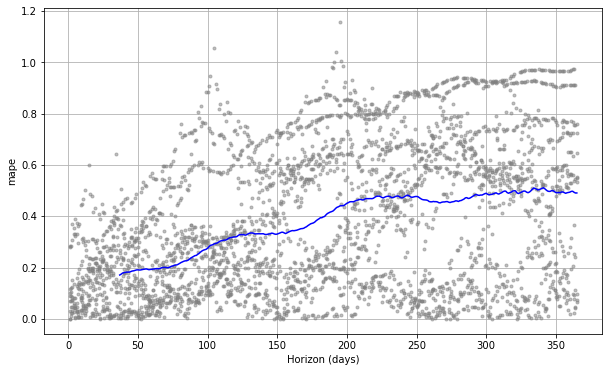

In [17]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')